In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
plt.rcParams['figure.figsize'] = (9,5)

In [3]:
# GPU check
torch.cuda.is_available(),torch.cuda.get_device_name(0)

(True, 'GeForce 920M')

## Basic Tensor Stuff

In [4]:
# Create Tensors
x = torch.tensor(5.)
w = torch.tensor(7.,requires_grad=True)
b = torch.tensor(9.,requires_grad=True)

In [5]:
print(x)
print(w)
print(b)

tensor(5.)
tensor(7., requires_grad=True)
tensor(9., requires_grad=True)


In [6]:
# Arithmetic operation 
y = w*x + 20*b

In [7]:
# Computing gradients
y.backward()

In [8]:
# Displaying
print('dy/dw: ',w.grad)
print('dy/db: ',b.grad)

dy/dw:  tensor(5.)
dy/db:  tensor(20.)


## Trying on sample data

In [9]:
data = np.genfromtxt('ex1data1.txt',delimiter =',')
data.shape

(97, 2)

In [10]:
data[:10]

array([[ 6.1101, 17.592 ],
       [ 5.5277,  9.1302],
       [ 8.5186, 13.662 ],
       [ 7.0032, 11.854 ],
       [ 5.8598,  6.8233],
       [ 8.3829, 11.886 ],
       [ 7.4764,  4.3483],
       [ 8.5781, 12.    ],
       [ 6.4862,  6.5987],
       [ 5.0546,  3.8166]])

In [11]:
inputs = data[:,0].astype('float32')
targets = data[:,1].astype('float32')

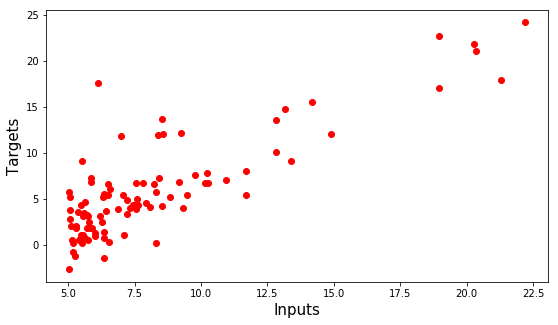

In [12]:
# Plotting the data
plt.scatter(inputs,targets,c='r')
plt.xlabel('Inputs',fontsize=15)
plt.ylabel('Targets',fontsize=15)
plt.show()

In [13]:
X = torch.from_numpy(inputs)
Y  = torch.from_numpy(targets)

## Linear Regression From Scratch

In [14]:
w = torch.zeros(1,requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [15]:
def mse(Y,preds):
    return torch.sum((Y-preds)**2)/Y.numel()

In [16]:
def prediction(X,w,b):
    return X*w +b

In [17]:
# Function to train
def train_loop(X,Y,w,b,num_epochs=100, lr=3e-4):
    hist_loss = []
    for _ in range(num_epochs):
        preds = prediction(X,w,b)
        loss = mse(Y,preds)
        hist_loss.append(loss)
        loss.backward()
        with torch.no_grad():
            w -= w.grad * lr
            b -= b.grad * lr
            w.grad.zero_()
            b.grad.zero_()
    return w,b,hist_loss

In [18]:
w,b,hist_cost = train_loop(X,Y,w,b)

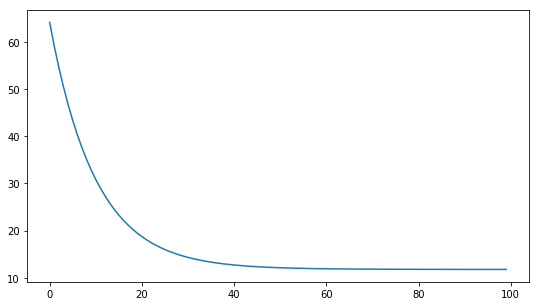

In [19]:
# Checking for convergence
plt.plot(hist_cost)
plt.show()

In [20]:
# Sample points for plotting the final model
x1 = min(X)-1
x2 = max(X)+2
y1 = prediction(x1,w,b)
y2 = prediction(x2,w,b)

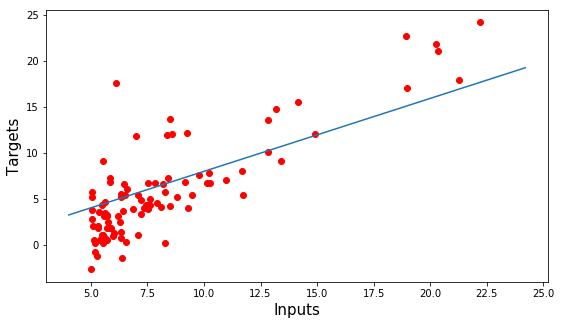

In [21]:
# Plotting the final model
plt.scatter(inputs,targets,c='r')
plt.plot([x1,x2],[y1,y2])
plt.xlabel('Inputs',fontsize=15)
plt.ylabel('Targets',fontsize=15)
plt.show()

## Using PyTorch built-ins

In [22]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [23]:
# Creating a Dataset
train_ds = TensorDataset(X,Y)
train_ds[0]

(tensor(6.1101), tensor(17.5920))

In [24]:
# Creating a temporary data loadaer for illustration purpose 
temp_dl = DataLoader(train_ds,batch_size=5,shuffle=True)
# Getting the next batch out of the data loader
next(iter(temp_dl))

[tensor([ 7.9334, 10.1360,  8.5781, 11.7000,  8.2111]),
 tensor([ 4.5623,  6.6799, 12.0000,  8.0043,  6.5426])]

In [25]:
# Actual data loader
train_dl = DataLoader(train_ds,batch_size=10,shuffle=True)

In [26]:
# Defining a model
model = nn.Linear(1,1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[-0.7226]], requires_grad=True)
Parameter containing:
tensor([0.8169], requires_grad=True)


In [27]:
# Creating a Loss Function and computing the current loss
import torch.nn.functional as F
loss_fn = F.mse_loss
loss = loss_fn(model(X.reshape(-1,1)),Y.reshape(-1,1))
print(loss)

tensor(182.5679, grad_fn=<MseLossBackward>)


In [28]:
# Function to train
def train(train_dl,model,num_epochs = 100):
    hist_loss = []
    epoch_loss = []
    optimizer = torch.optim.SGD(model.parameters(),lr = 3e-5)
    loss_fn = F.mse_loss
    for _ in range(num_epochs):
        for batch_x,batch_y in train_dl:
            preds = model(batch_x.reshape(-1,1))
            loss = loss_fn(preds,batch_y.reshape(-1,1))
            hist_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss.append(sum(hist_loss)/len(hist_loss))
        hist_loss = []
        
    return model,epoch_loss

In [29]:
final_model,hist_cost = train(train_dl,model)

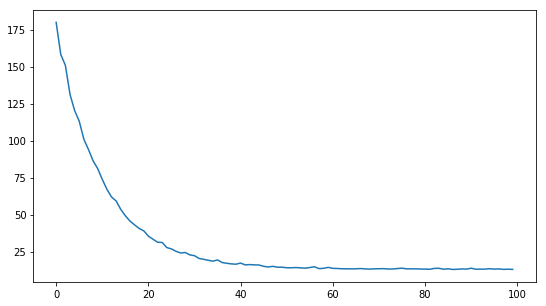

In [30]:
# Checking for convergence
plt.plot(hist_cost)
plt.show()

In [31]:
# Sample points for plotting the final model
y1 = final_model(x1.reshape(1,1))
y2 = final_model(x2.reshape(1,1))

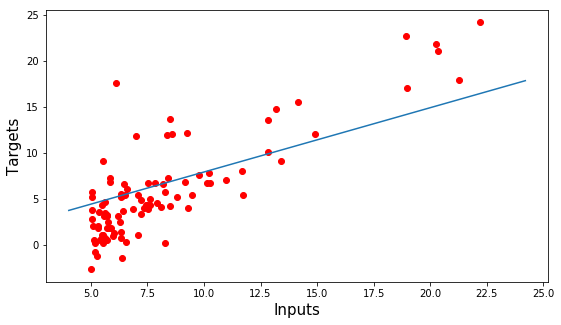

In [32]:
# Plotting the final model
plt.scatter(inputs,targets,c='r')
plt.plot([x1,x2],[y1,y2])
plt.xlabel('Inputs',fontsize=15)
plt.ylabel('Targets',fontsize=15)
plt.show()